## Multi-output facial attribute classification.

The aim of the project to do binary classification for three facial attributes that is:
<ul>
<li>Gender
<li>Smiling
<li>Young
</ul>

Successful conclusion would be achieving predictions that match actual attribute.



### Importing necessary libraries 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pylab as plt

#Checking tensorflow version and ensuring it is above 2.5.X to support Python 3.9
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)


TF version: 2.10.0
Hub version: 0.12.0


In [2]:
#set PATH variable to location of data set in local directory/storage.
PATH = "D:/DL Project/"

ATTR_PATH = PATH + "list_attr_celeba.csv"  
PARTITION_PATH = PATH + "list_eval_partition.csv"
IMAGES_PATH = PATH +"img_align_celeba/img_align_celeba/"

### Creating dataframe, preprocessing and utility functions

In [3]:
df = pd.merge(pd.read_csv(PARTITION_PATH), pd.read_csv(ATTR_PATH), on="image_id")
df.head()

,image_id,partition,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,-1,1,1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,0,-1,-1,-1,1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,0,-1,-1,-1,-1,-1,-1,1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,0,-1,-1,1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,0,-1,1,1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [5]:
BATCH_SIZE = 128
#MODEL_HANDLE is the variable in which we are saving pretrained weights from Efficientnet_v2 used to extract feature vector
MODEL_HANDLE = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2" 
IMAGE_SIZE = (224, 224)

#### Utility functions to preprocess, load and preprocess images and building dataset with relevant features only

In [6]:
# Preprocess_image iis used to resize all images into 224 X 224 pixels
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

# load_and_preprocess 
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

# load_and_preprocess_from_path_label function 
def load_and_preprocess_from_path_label(path, male, smiling, young):
    images = load_and_preprocess_image(path)
    return images, male, smiling, young
'''
build_data_from_df utilizes the above funcions to build dataset from the original Dataframe of CelebA and remove attributes-
that are out of scope of defined problem statement.
'''
def build_dataset_from_df(df):
    ds = tf.data.Dataset.from_tensor_slices((
        [IMAGES_PATH + image_id for image_id in df["image_id"]],
        list(df["Male"].replace(-1, 0)),
        list(df["Smiling"].replace(-1, 0)),
        list(df["Young"].replace(-1, 0))
    ))
    ds = ds.map(load_and_preprocess_from_path_label)
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


In [7]:
# train_ds and val_ds are the new Dataframe object containing attributes- young, smiling and male

train_df = df.loc[df["partition"] == 0]
train_ds = build_dataset_from_df(train_df)

val_df = df.loc[df["partition"] == 1]
val_ds = build_dataset_from_df(val_df)

In [8]:
for image, male, smiling, young in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label gender: ", male.shape)
    print("Label smiling: ", smiling.shape)
    print("Label young: ", young.shape)

Image shape:  (128, 224, 224, 3)
Label gender:  (128,)
Label smiling:  (128,)
Label young:  (128,)


### Visualization of images with their actual facial attributes

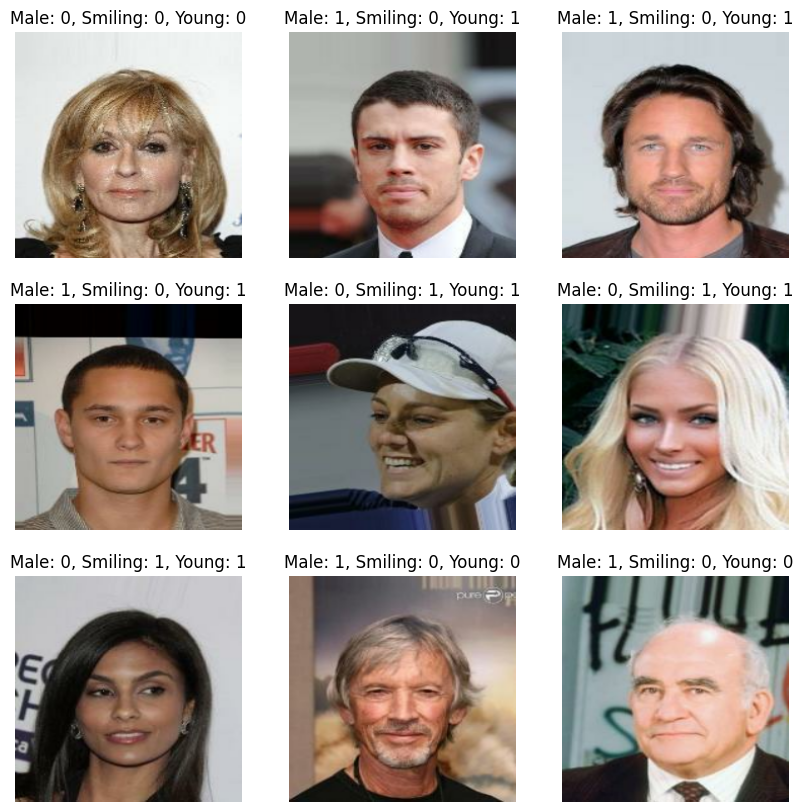

In [9]:
image, male, smiling, young = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    s = f"Male: {male[i].numpy()}, Smiling: {smiling[i].numpy()}, Young: {young[i].numpy()}"
    plt.title(s)
    plt.axis("off")

### Normalization and data augmentation layers to remove inconsistencies in data set

In [10]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False
if do_data_augmentation:
    preprocessing_model.add(tf.keras.layers.RandomRotation(0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0.2, 0))
    preprocessing_model.add(tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, male, smiling, young:
                        (preprocessing_model(images), (male, smiling, young)))

val_ds = val_ds.map(lambda images, male, smiling, young:
                    (normalization_layer(images), (male, smiling, young)))

## Building the Model

In [11]:
do_fine_tuning = False
input = tf.keras.Input(shape=IMAGE_SIZE + (3,))
x = hub.KerasLayer(MODEL_HANDLE, trainable=do_fine_tuning)(input)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)

out_male = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name='male')(x)
out_smiling = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name='smiling')(x)
out_young = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name='young')(x)

model = tf.keras.Model( inputs = input, outputs = [out_male, out_smiling, out_young])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 keras_layer (KerasLayer)       (None, 1280)         5919312     ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1280)         0           ['keras_layer[0][0]']            
                                                                                                  
 dense (Dense)                  (None, 128)          163968      ['dropout[0][0]']            

In [12]:
model.compile(
    loss = {
        "male": tf.keras.losses.BinaryCrossentropy(),
        "smiling": tf.keras.losses.BinaryCrossentropy(),
        "young": tf.keras.losses.BinaryCrossentropy()
    },
    metrics = {
        "male": 'accuracy',
        "smiling": 'accuracy',
        "young": 'accuracy'
    },
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

### Training the model

In [13]:
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=3, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/3
1271/1271 [==============================] - 3847s 3s/step - loss: 0.8622 - male_loss: 0.1247 - smiling_loss: 0.4109 - young_loss: 0.3261 - male_accuracy: 0.9520 - smiling_accuracy: 0.8099 - young_accuracy: 0.8640 - val_loss: 0.7642 - val_male_loss: 0.0855 - val_smiling_loss: 0.3507 - val_young_loss: 0.3275 - val_male_accuracy: 0.9666 - val_smiling_accuracy: 0.8498 - val_young_accuracy: 0.8594
Epoch 2/3
1271/1271 [==============================] - 3746s 3s/step - loss: 0.7929 - male_loss: 0.1054 - smiling_loss: 0.3796 - young_loss: 0.3073 - male_accuracy: 0.9593 - smiling_accuracy: 0.8276 - young_accuracy: 0.8724 - val_loss: 0.7478 - val_male_loss: 0.0798 - val_smiling_loss: 0.3391 - val_young_loss: 0.3285 - val_male_accuracy: 0.9695 - val_smiling_accuracy: 0.8509 - val_young_accuracy: 0.8605
Epoch 3/3
1271/1271 [==============================] - 3747s 3s/step - loss: 0.7708 - male_loss: 0.0989 - smiling_loss: 0.3695 - young_loss: 0.3019 - male_accuracy: 0.9621 - smiling_accu

In [23]:
hist

{'loss': [0.8621907830238342, 0.7928568124771118, 0.7707589864730835],
 'male_loss': [0.12472067028284073, 0.10539133846759796, 0.09892390668392181],
 'smiling_loss': [0.41085001826286316,
  0.37964698672294617,
  0.3695099353790283],
 'young_loss': [0.3260566294193268, 0.3073425889015198, 0.3018992841243744],
 'male_accuracy': [0.9520493149757385, 0.9592840075492859, 0.9620869159698486],
 'smiling_accuracy': [0.8098999261856079,
  0.8276086449623108,
  0.8331591486930847],
 'young_accuracy': [0.8639727830886841, 0.872393786907196, 0.8746373653411865],
 'val_loss': [0.7642360329627991, 0.7478486895561218, 0.7404118180274963],
 'val_male_loss': [0.08553789556026459,
  0.07982660830020905,
  0.07828792184591293],
 'val_smiling_loss': [0.35069721937179565,
  0.3391178250312805,
  0.3315522372722626],
 'val_young_loss': [0.3274909555912018,
  0.32845795154571533,
  0.33016806840896606],
 'val_male_accuracy': [0.9665826559066772,
  0.969506025314331,
  0.9682963490486145],
 'val_smiling_acc

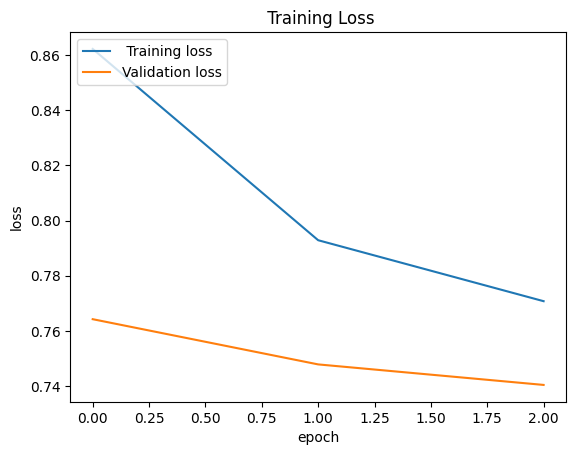

In [26]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title(' Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend([' Training loss', 'Validation loss'], loc='upper left')
plt.show()

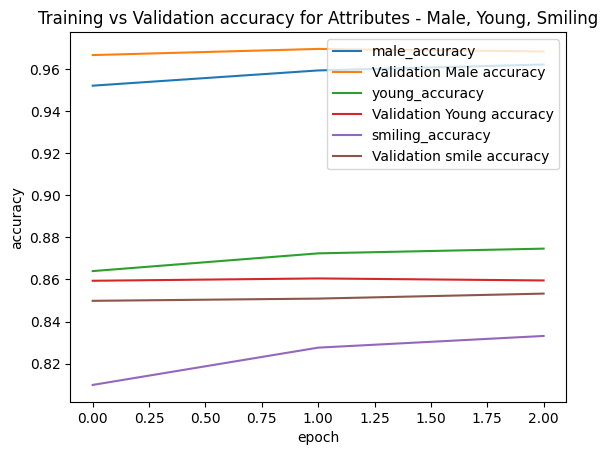

In [28]:
plt.plot(hist['male_accuracy'])
plt.plot(hist['val_male_accuracy'])
plt.plot(hist['young_accuracy'])
plt.plot(hist['val_young_accuracy'])
plt.plot(hist['smiling_accuracy'])
plt.plot(hist['val_smiling_accuracy'])
plt.plot

plt.title('Training vs Validation accuracy for Attributes - Male, Young, Smiling')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['male_accuracy', 'Validation Male accuracy', 'young_accuracy', 'Validation Young accuracy','smiling_accuracy', 'Validation smile accuracy'], loc='upper right')
plt.show()

### Testing

Taking a random image from constructed dataset and predicting probability of person in the picture being Male, Young and Smiling and then doing binary classification to give a 0 or 1 to indicate presence of attribute.

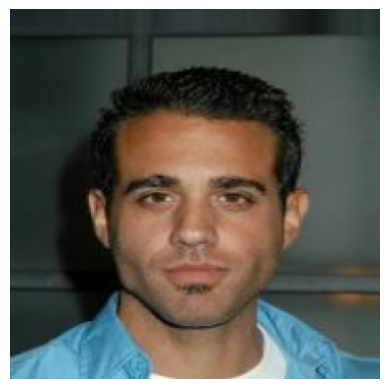

1/1 [==============================] - 0s 47ms/step
Male: actual 1, predicted 1 (0.9998)
Smiling: actual 0, predicted 0 (0.1421)
Young: actual 1, predicted 1 (0.9257)


In [30]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = model.predict(np.expand_dims(image, axis=0))
for i, label in enumerate(["Male", "Smiling", "Young"]):
    pred = prediction_scores[i][0][0]
    print(f"{label}: actual {y[i][0]}, predicted {1 if pred > 0.5 else 0} ({format(pred, '.4f')})")

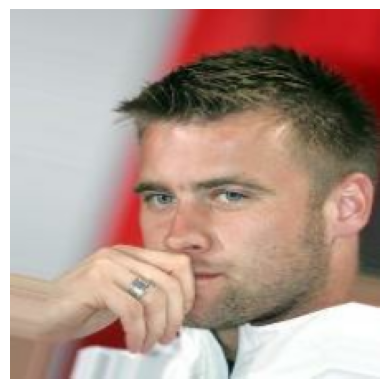

1/1 [==============================] - 0s 49ms/step
Male: actual 1, predicted 1 (0.9970)
Smiling: actual 0, predicted 0 (0.0738)
Young: actual 1, predicted 1 (0.8993)


In [31]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = model.predict(np.expand_dims(image, axis=0))
for i, label in enumerate(["Male", "Smiling", "Young"]):
    pred = prediction_scores[i][0][0]
    print(f"{label}: actual {y[i][0]}, predicted {1 if pred > 0.5 else 0} ({format(pred, '.4f')})")

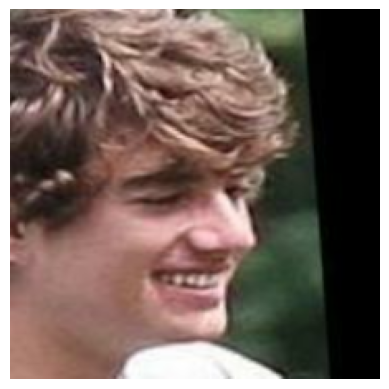

1/1 [==============================] - 0s 51ms/step
Male: actual 1, predicted 1 (0.7063)
Smiling: actual 1, predicted 0 (0.1964)
Young: actual 1, predicted 1 (0.7718)


In [32]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = model.predict(np.expand_dims(image, axis=0))
for i, label in enumerate(["Male", "Smiling", "Young"]):
    pred = prediction_scores[i][0][0]
    print(f"{label}: actual {y[i][0]}, predicted {1 if pred > 0.5 else 0} ({format(pred, '.4f')})")